In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import shap
import matplotlib.pyplot as plt
import astartes
from vsa_explainer import visualize_vsa_contributions
from rdkit.Chem.Draw import rdMolDraw2D, MolToImage
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFMCS
from IPython.display import SVG, display
# Config
DATA_PATH = "manuscript/B3DB_regression.tsv"
SMILES_COL = "SMILES"
TARGET_COL = "logBB"
RANDOM_STATE = 142

plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.sans-serif': 'Segoe UI'})
plt.rcParams.update({'font.size': 26})

C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_descriptors(mol, descriptor_names):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    return calc.CalcDescriptors(mol)

In [3]:
# Load dataset
df = pd.read_csv(DATA_PATH, sep = '\t')
df = df.dropna(subset=[SMILES_COL, TARGET_COL])

In [4]:
# Load dataset
df = pd.read_csv(DATA_PATH, sep = '\t')
df = df.dropna(subset=[SMILES_COL, TARGET_COL])

# Convert SMILES to RDKit mol
df["mol"] = df[SMILES_COL].apply(Chem.MolFromSmiles)
df = df[df["mol"].notna()].reset_index(drop=True)

# Compute all RDKit descriptors if not cached
cached_file = "manuscript/descriptor_cache.csv"
try:
    X = pd.read_csv(cached_file)
    print("Loaded cached descriptors.")
except FileNotFoundError:
    descriptor_names = [d[0] for d in Descriptors.descList]
    print(f"Calculating {len(descriptor_names)} descriptors for {len(df)} molecules...")
    X = pd.DataFrame([compute_descriptors(m, descriptor_names) for m in df["mol"]], columns=descriptor_names)
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    X.to_csv(cached_file, index=False)

Loaded cached descriptors.


In [5]:
y = df[TARGET_COL].astype(float)

# --- Scaffold split ---
splits = astartes.train_test_split(
    df[SMILES_COL],
    return_indices=True,
    test_size=0.2,
    random_state=RANDOM_STATE,
    sampler='scaffold'
)
train_idx, test_idx = list(splits[4]), list(splits[5])

# --- Force molecules of interest into test set ---
propranolol = 'CC(C)NCC(COC1=CC=CC2=CC=CC=C21)O'
atenolol = 'CC(C)NCC(COC1=CC=C(C=C1)CC(=O)N)O'
metoprolol = 'CC(C)NCC(COC1=CC=C(C=C1)CCOC)O'
oxprenolol = 'CC(C)NCC(COC1=CC=CC=C1OCC=C)O'
molecules_of_interest = [propranolol, atenolol, metoprolol, oxprenolol]
molecules_of_interest = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in molecules_of_interest]
canonical_smiles = df[SMILES_COL].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
for smi in molecules_of_interest:
    matches = np.where(canonical_smiles == smi)[0]
    for idx in matches:
        if idx in train_idx:
            train_idx.remove(idx)
            test_idx.append(idx)
        elif idx not in test_idx:
            test_idx.append(idx)

# --- Create final splits ---
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\astartes\utils\array_type_helpers.py:19: ConversionWarning: Attempting to cast X to a numpy array, which may result in unexpected behavior (remove this warning by passing numpy arrays directly to astartes).
  warnings.warn(
C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\astartes\main.py:348: NormalizationWarning: Requested train/test split (0.75, 0.20) do not sum to 1.0, normalizing to train=0.79, test=0.21.
  warn(
C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\astartes\samplers\extrapolation\scaffold.py:48: NoMatchingScaffold: No matching scaffold was found for the 117 molecules corresponding to indices {517, 1036, 525, 1037, 527, 1038, 1040, 1048, 539, 549, 40, 566, 571, 572, 577, 584, 588, 597, 598, 599, 600, 601, 602, 603, 605, 97, 613, 104, 619, 630, 634, 125, 640, 642, 643, 644, 133, 653, 143, 144, 147, 662, 666, 667, 668, 160, 681, 172, 684, 685, 181, 697, 699, 710, 

In [6]:
# Train Random Forest model
rf = RandomForestRegressor(n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1,
                           max_depth = 20)
rf.fit(X_train, y_train)

# Model evaluation
y_pred = rf.predict(X_test)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test r:", pearsonr(y_test, y_pred)[0])

Test RMSE: 0.5709878181665146
Test r: 0.7157743831759529


In [7]:
pearsonr(y_test, y_pred)[1]

1.2487196725910201e-36

In [8]:
print(len(X_train), len(X_test))

833 225


p = 0.0000


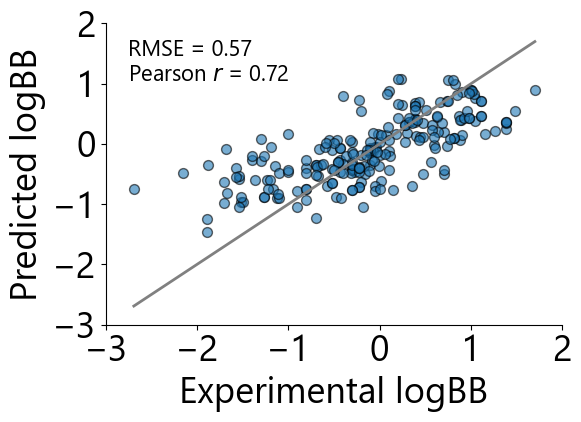

In [9]:
# Parity plot
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.scatter(y_test, y_pred, color = "tab:blue", alpha=0.6, edgecolor="black", s = 50)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, "gray", linewidth=2)
ax.set_xlim([-3, 2])
ax.set_xticks([-3, -2, -1, 0, 1, 2])
ax.set_ylim([-3, 2])
ax.set_yticks([-3, -2, -1, 0, 1, 2])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r = pearsonr(y_test, y_pred)
r_value = r[0]
plt.text(0.05, 0.95,
         f"RMSE = {rmse:.2f}\nPearson $r$ = {r_value:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment="top",
         fontsize=16,
         )
print(f'p = {r[1]:.4f}')
plt.xlabel("Experimental logBB")
plt.ylabel("Predicted logBB")
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

Ensemble across 20 random seeds

In [12]:
rmse = np.zeros(30)
r = np.zeros(30)
for i in range(30):
    y = df[TARGET_COL].astype(float)
    # --- Scaffold split ---
    splits = astartes.train_test_split(
        df[SMILES_COL],
        return_indices=True,
        test_size=0.2,
        random_state=RANDOM_STATE,
        sampler='scaffold'
    )
    train_idx, test_idx = list(splits[4]), list(splits[5])

    # --- Force molecules of interest into test set ---
    propranolol = 'CC(C)NCC(COC1=CC=CC2=CC=CC=C21)O'
    atenolol = 'CC(C)NCC(COC1=CC=C(C=C1)CC(=O)N)O'
    metoprolol = 'CC(C)NCC(COC1=CC=C(C=C1)CCOC)O'
    oxprenolol = 'CC(C)NCC(COC1=CC=CC=C1OCC=C)O'
    molecules_of_interest = [propranolol, atenolol, metoprolol, oxprenolol]
    molecules_of_interest = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in molecules_of_interest]
    canonical_smiles = df[SMILES_COL].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
    for smi in molecules_of_interest:
        matches = np.where(canonical_smiles == smi)[0]
        for idx in matches:
            if idx in train_idx:
                train_idx.remove(idx)
                test_idx.append(idx)
            elif idx not in test_idx:
                test_idx.append(idx)

    # --- Create final splits ---
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    # Train Random Forest model
    rf = RandomForestRegressor(n_estimators=800, random_state=RANDOM_STATE+i, n_jobs=-1,
                            max_depth = 20)
    rf.fit(X_train, y_train)

    # Model evaluation
    y_pred = rf.predict(X_test)
    rmse[i] = np.sqrt(mean_squared_error(y_test, y_pred))
    r[i] = pearsonr(y_test, y_pred)[0]

print("Average Test RMSE:", np.mean(rmse))
print("Average Test r:", np.mean(r))

C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\astartes\utils\array_type_helpers.py:19: ConversionWarning: Attempting to cast X to a numpy array, which may result in unexpected behavior (remove this warning by passing numpy arrays directly to astartes).
  warnings.warn(
C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\astartes\main.py:348: NormalizationWarning: Requested train/test split (0.75, 0.20) do not sum to 1.0, normalizing to train=0.79, test=0.21.
  warn(
C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\astartes\samplers\extrapolation\scaffold.py:48: NoMatchingScaffold: No matching scaffold was found for the 117 molecules corresponding to indices {517, 1036, 525, 1037, 527, 1038, 1040, 1048, 539, 549, 40, 566, 571, 572, 577, 584, 588, 597, 598, 599, 600, 601, 602, 603, 605, 97, 613, 104, 619, 630, 634, 125, 640, 642, 643, 644, 133, 653, 143, 144, 147, 662, 666, 667, 668, 160, 681, 172, 684, 685, 181, 697, 699, 710, 

Average Test RMSE: 0.5699834296914109
Average Test r: 0.7168036010067146


In [ ]:
print("STDev Test RMSE:", np.std(rmse)s)
print("STDev Test r:", np.std(r))

STDev Test RMSE: 0.001519951756541242
STDev Test r: 0.0019290825425369367


In [18]:
from scipy.stats import spearmanr
bps  = [0.2, 12, 26, 50]
feat_vals = [26, 26, 50.2, 38.6]
print("r:", spearmanr(bps, feat_vals)[0])
print("p-value:", spearmanr(bps, feat_vals)[1])

r: 0.7378647873726218
p-value: 0.2621352126273781


In [23]:
from scipy.stats import spearmanr
bps  = np.array([0.2, 12, 26, 50])
feat_vals = np.array([5.4, 10.6, 5.7, 11.1])
print("r:", spearmanr(bps, feat_vals)[0])
print("p-value:", spearmanr(bps, feat_vals)[1])

r: 0.7999999999999999
p-value: 0.20000000000000007


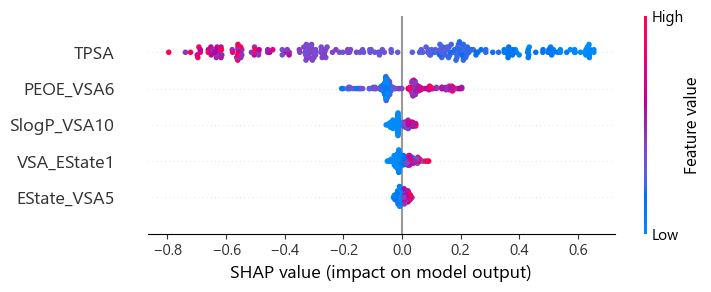

In [10]:
# SHAP explanations
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
# SHAP summary plot (beeswarm)
plt.figure(figsize=(6.4, 4.8))
shap.summary_plot(shap_values, X_test, show=    True, max_display=5)

In [11]:
max_row = df.loc[df[TARGET_COL].idxmax()]
min_row = df.loc[df[TARGET_COL].idxmin()]

molecule_max = max_row[SMILES_COL]
molecule_min = min_row[SMILES_COL]

In [12]:
min_row[TARGET_COL]

-2.69

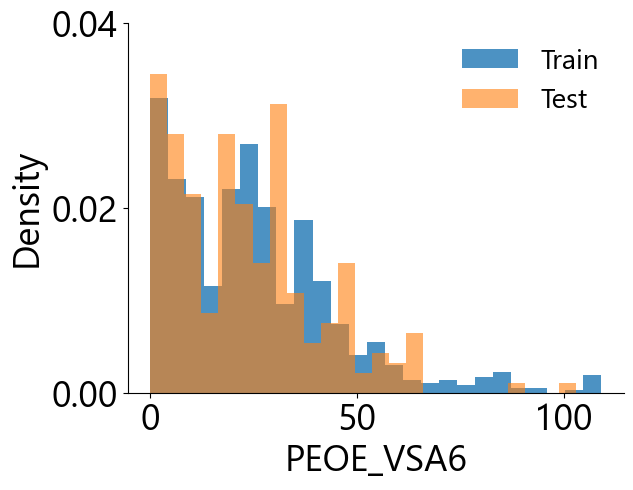

In [13]:
#plot a histogram of the distribution of the feature variables in the test and train sets
#both sets on the same plot different series
plt.figure()
feature_to_plot = 'PEOE_VSA6'
plt.hist(X_train[feature_to_plot], bins=25, alpha=0.8, label='Train', color='tab:blue', density=True)
plt.hist(X_test[feature_to_plot], bins=25, alpha=0.6, label='Test', color='tab:orange', density=True)
plt.xlabel(feature_to_plot)
plt.ylabel("Density")
plt.yticks([0, 0.02, 0.04])
#remove top and right plot borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#remove box around legend labels
plt.legend(frameon=False, fontsize = 20)

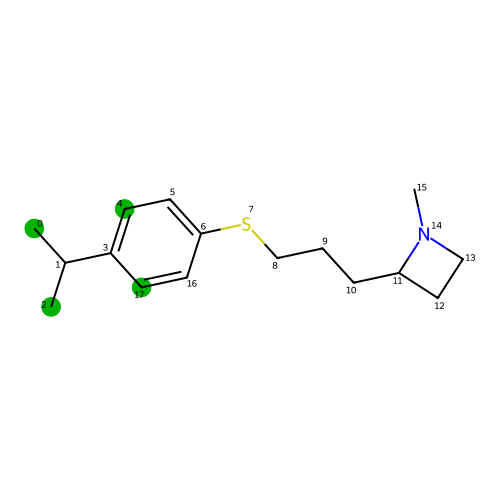


### PEOE_VSA6 Contributions — Total: 25.9802
Bin range: -0.1000 to -0.0500
Idx Sym   Charge     Contrib  % of total
--------------------------------------------
0   C     -0.059       6.924        26.7%
2   C     -0.059       6.924        26.7%
4   C     -0.058       6.066        23.3%
17  C     -0.058       6.066        23.3%


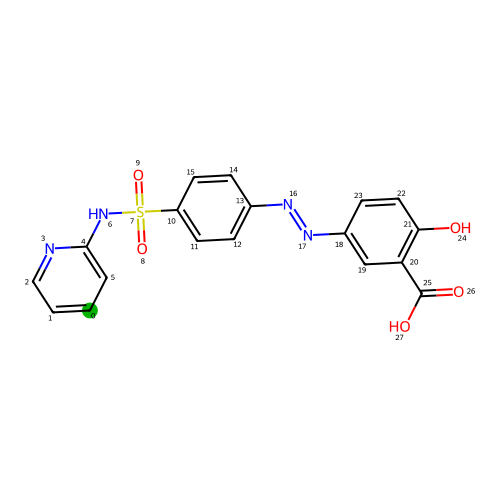


### PEOE_VSA6 Contributions — Total: 6.0664
Bin range: -0.1000 to -0.0500
Idx Sym   Charge     Contrib  % of total
--------------------------------------------
0   C     -0.057       6.066       100.0%


In [14]:
#Visualize PEOE_VSA6 contributions for the molecule with the highest and lowest logBB
visualize_vsa_contributions(molecule_max, ["PEOE_VSA6"])
visualize_vsa_contributions(molecule_min, ["PEOE_VSA6"])

Beta blocker BBB permeability example

In [15]:
proponaol = 'CC(C)NCC(COC1=CC=CC2=CC=CC=C21)O'
atenolol = 'CC(C)NCC(COC1=CC=C(C=C1)CC(=O)N)O'
metoprolol = 'CC(C)NCC(COC1=CC=C(C=C1)CCOC)O'
oxprenolol = 'CC(C)NCC(COC1=CC=CC=C1OCC=C)O'
mols = [Chem.MolFromSmiles(atenolol),Chem.MolFromSmiles(metoprolol),
          Chem.MolFromSmiles(proponaol), Chem.MolFromSmiles(oxprenolol)]
names = ['atenolol', 'metoprolol', 'proponaol', 'oxprenolol']
mcs_result = rdFMCS.FindMCS(mols)
mcs_smarts = mcs_result.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)

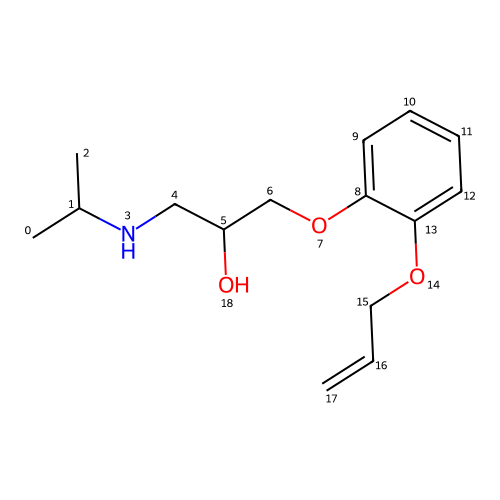

In [16]:
#save image of each API
mol =  Chem.MolFromSmiles(oxprenolol)
drawer = rdMolDraw2D.MolDraw2DSVG(500, 500)
drawer.drawOptions().addAtomIndices = True
rdMolDraw2D.PrepareAndDrawMolecule(
    drawer, mol
)
drawer.FinishDrawing()
svg_text = drawer.GetDrawingText()
display(SVG(svg_text))
save_path = 'manuscript/Figure_4/' + f'{names[3]}.svg'
with open(save_path, "w") as f: 
    f.write(svg_text)

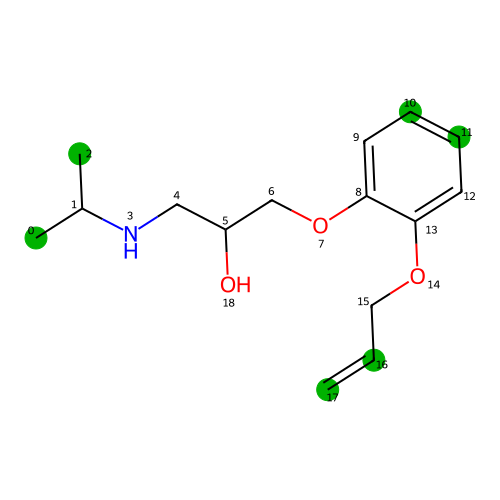

Saved SVG to manuscript/Figure_4/oxprenolol_peoe.svg

### PEOE_VSA6 Contributions — Total: 38.6352
Bin range: -0.1000 to -0.0500
Idx Sym   Charge     Contrib  % of total
--------------------------------------------
0   C     -0.050       6.924        17.9%
2   C     -0.050       6.924        17.9%
10  C     -0.058       6.066        15.7%
11  C     -0.058       6.066        15.7%
16  C     -0.055       6.076        15.7%
17  C     -0.100       6.579        17.0%


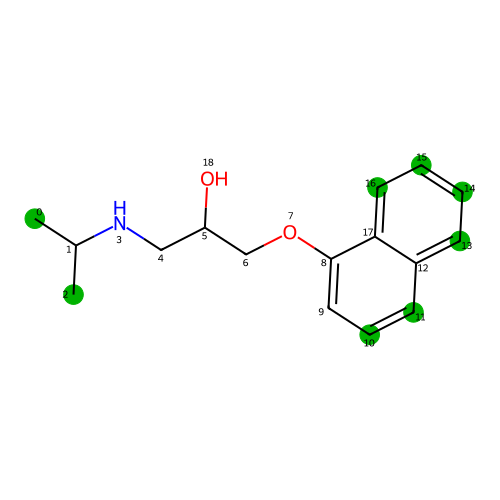

Saved SVG to manuscript/Figure_4/proponaol_peoe.svg

### PEOE_VSA6 Contributions — Total: 50.2457
Bin range: -0.1000 to -0.0500
Idx Sym   Charge     Contrib  % of total
--------------------------------------------
0   C     -0.050       6.924        13.8%
2   C     -0.050       6.924        13.8%
10  C     -0.058       6.066        12.1%
11  C     -0.054       6.066        12.1%
13  C     -0.054       6.066        12.1%
14  C     -0.062       6.066        12.1%
15  C     -0.061       6.066        12.1%
16  C     -0.051       6.066        12.1%


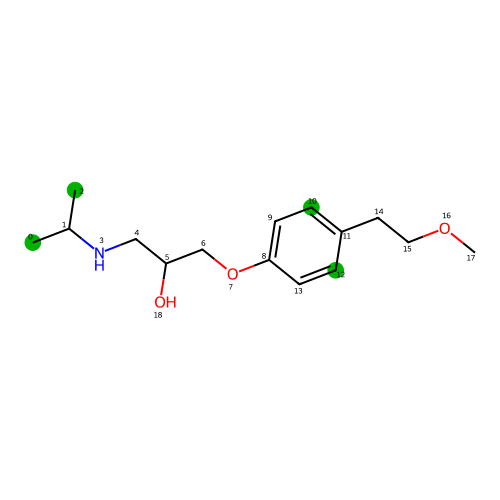

Saved SVG to manuscript/Figure_4/metoprolol_peoe.svg

### PEOE_VSA6 Contributions — Total: 25.9802
Bin range: -0.1000 to -0.0500
Idx Sym   Charge     Contrib  % of total
--------------------------------------------
0   C     -0.050       6.924        26.7%
2   C     -0.050       6.924        26.7%
10  C     -0.055       6.066        23.3%
12  C     -0.055       6.066        23.3%


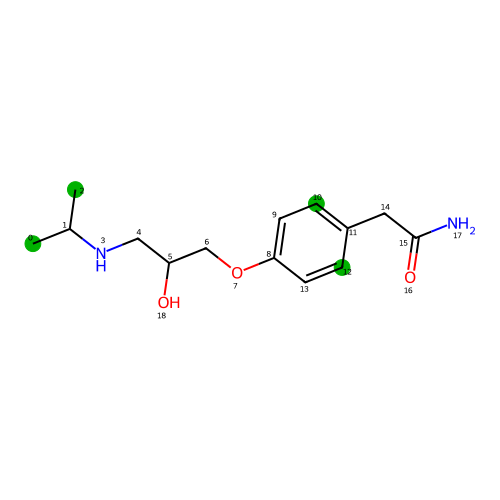

Saved SVG to manuscript/Figure_4/atenolol_peoe.svg

### PEOE_VSA6 Contributions — Total: 25.9802
Bin range: -0.1000 to -0.0500
Idx Sym   Charge     Contrib  % of total
--------------------------------------------
0   C     -0.050       6.924        26.7%
2   C     -0.050       6.924        26.7%
10  C     -0.055       6.066        23.3%
12  C     -0.055       6.066        23.3%


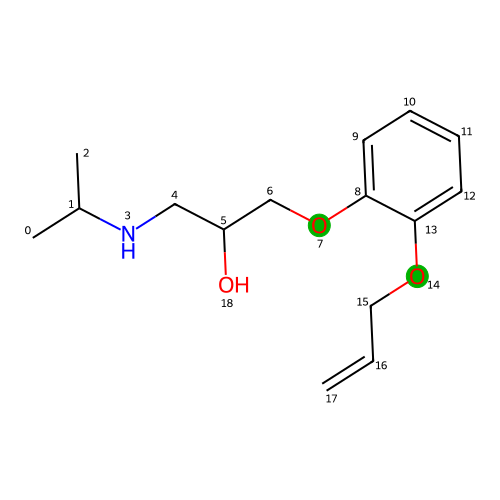

Saved SVG to manuscript/Figure_4/oxprenolol_estate.svg

### VSA_EState1 Contributions — Total: 11.0555
Bin range: -inf to 4.7800
Idx Sym    Value     Contrib  % of total
--------------------------------------------
7   O      4.737       5.579        50.5%
14  O      4.737       5.476        49.5%


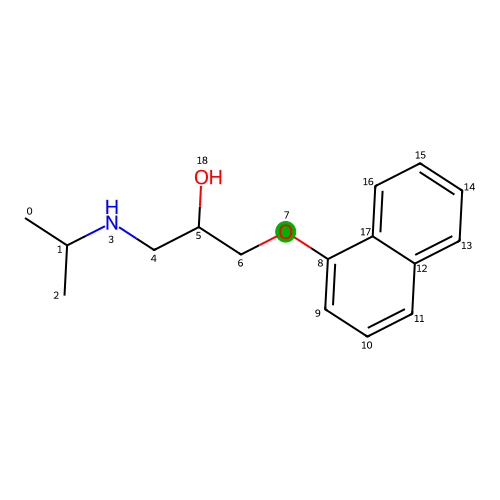

Saved SVG to manuscript/Figure_4/proponaol_estate.svg

### VSA_EState1 Contributions — Total: 5.7234
Bin range: -inf to 4.7800
Idx Sym    Value     Contrib  % of total
--------------------------------------------
7   O      4.737       5.723       100.0%


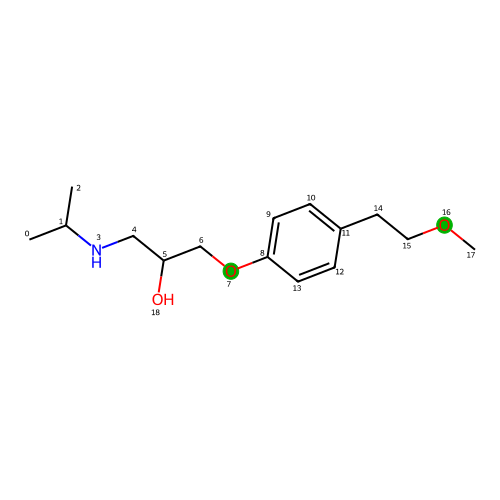

Saved SVG to manuscript/Figure_4/metoprolol_estate.svg

### VSA_EState1 Contributions — Total: 10.5681
Bin range: -inf to 4.7800
Idx Sym    Value     Contrib  % of total
--------------------------------------------
7   O      4.737       5.538        52.4%
16  O      4.737       5.030        47.6%


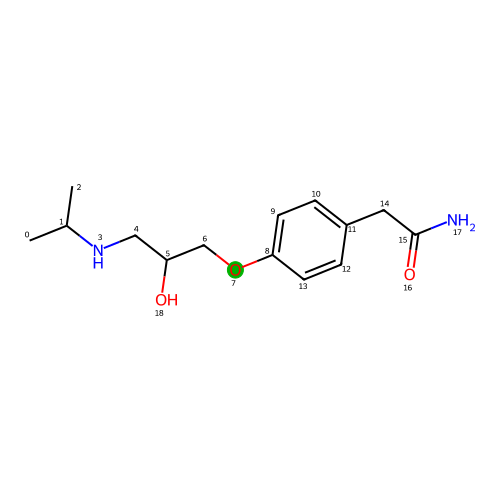

Saved SVG to manuscript/Figure_4/atenolol_estate.svg

### VSA_EState1 Contributions — Total: 5.4539
Bin range: -inf to 4.7800
Idx Sym    Value     Contrib  % of total
--------------------------------------------
7   O      4.737       5.454       100.0%


In [17]:
visualize_vsa_contributions(oxprenolol, ["PEOE_VSA6"], save_path= 'manuscript/Figure_4/oxprenolol_peoe.svg')
visualize_vsa_contributions(proponaol, ["PEOE_VSA6"], save_path= 'manuscript/Figure_4/proponaol_peoe.svg')
visualize_vsa_contributions(metoprolol, ["PEOE_VSA6"],  save_path= 'manuscript/Figure_4/metoprolol_peoe.svg')
visualize_vsa_contributions(atenolol, ["PEOE_VSA6"], save_path= 'manuscript/Figure_4/atenolol_peoe.svg')

visualize_vsa_contributions(oxprenolol, ["VSA_EState1"], save_path= 'manuscript/Figure_4/oxprenolol_estate.svg')
visualize_vsa_contributions(proponaol, ["VSA_EState1"], save_path= 'manuscript/Figure_4/proponaol_estate.svg')
visualize_vsa_contributions(metoprolol, ["VSA_EState1"],  save_path= 'manuscript/Figure_4/metoprolol_estate.svg')
visualize_vsa_contributions(atenolol, ["VSA_EState1"], save_path= 'manuscript/Figure_4/atenolol_estate.svg')


SHAP values for CC(C)NCC(COC1=CC=C(C=C1)CC(=O)N)O:


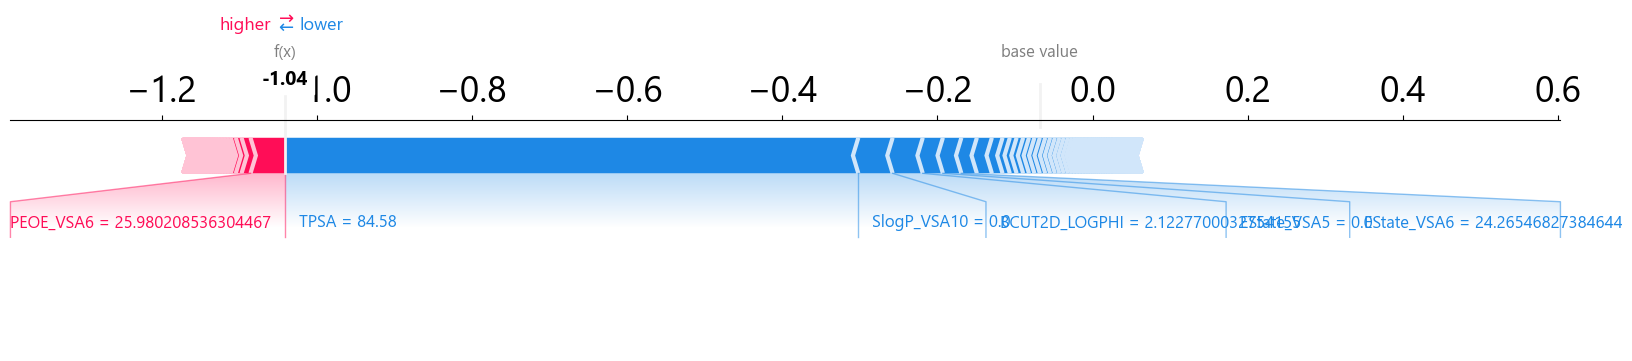

SHAP values for CC(C)NCC(COC1=CC=C(C=C1)CCOC)O:


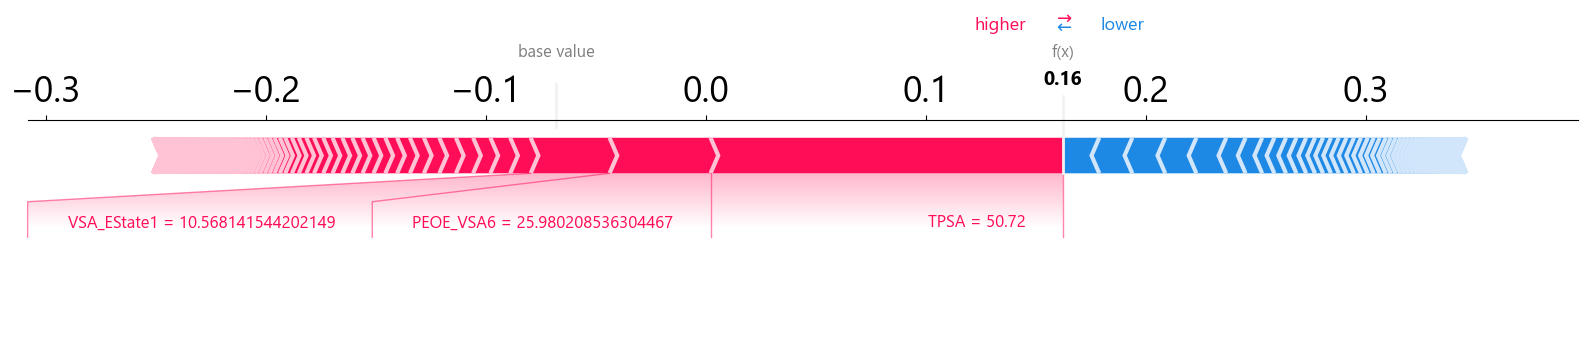

SHAP values for CC(C)NCC(COC1=CC=CC2=CC=CC=C21)O:


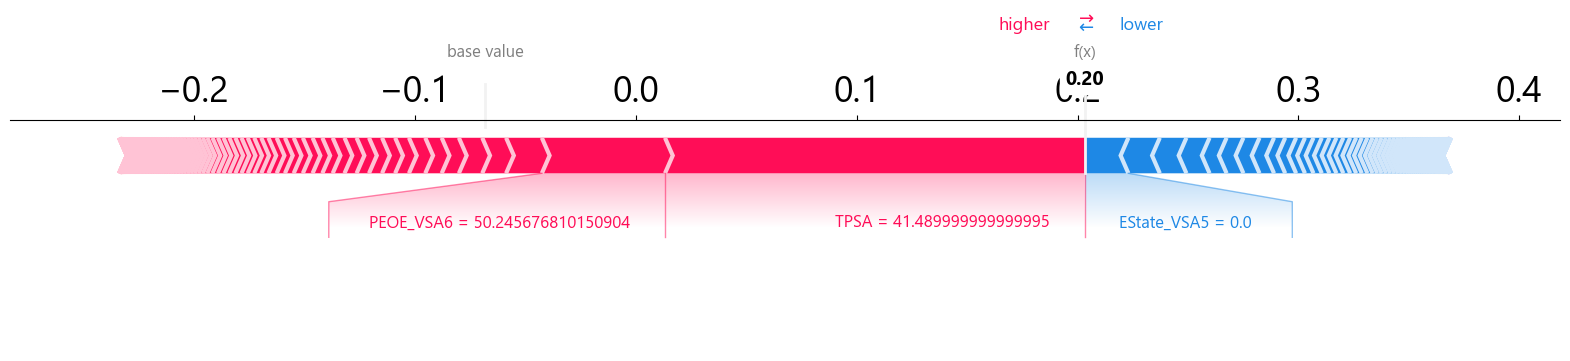

SHAP values for CC(C)NCC(COC1=CC=CC=C1OCC=C)O:


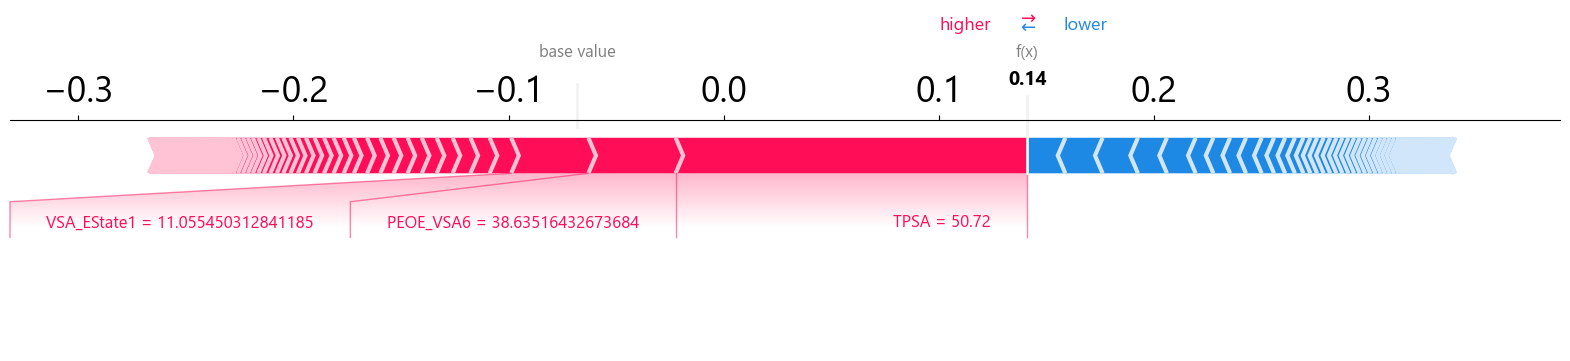

In [18]:
#Individual SHAP explanations to find per-molecule SHAP features
beta_blocker_smiles = [atenolol, metoprolol, propranolol, oxprenolol]
X_new = pd.DataFrame([compute_descriptors(Chem.MolFromSmiles(smi), X.columns) for smi in beta_blocker_smiles], columns=X.columns)
X_new = X_new.replace([np.inf, -np.inf], np.nan).fillna(0)
shap_values_new = explainer(X_new)

# Force plot for a single molecule
for i in range(len(beta_blocker_smiles)):
    print(f"SHAP values for {beta_blocker_smiles[i]}:")
    shap.plots.force(
        explainer.expected_value,
        shap_values_new.values[i],
        X_new.iloc[i],
        matplotlib=True
    )



In [19]:
#predicted BBB for beta blockers
for i, smi in enumerate(beta_blocker_smiles):
    pred = rf.predict(X_new.iloc[i].values.reshape(1, -1))
    print(f"Predicted logBB for {smi}: {pred[0]:.2f}")

c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted logBB for CC(C)NCC(COC1=CC=C(C=C1)CC(=O)N)O: -1.04
Predicted logBB for CC(C)NCC(COC1=CC=C(C=C1)CCOC)O: 0.16


c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted logBB for CC(C)NCC(COC1=CC=CC2=CC=CC=C21)O: 0.20


c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted logBB for CC(C)NCC(COC1=CC=CC=C1OCC=C)O: 0.14


Examples from med chem paper

c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted logBB for molecule 32: -0.76


c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted logBB for molecule 33: 0.37
Predicted logBB for molecule 34: 0.38


c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


SHAP values for O=S(C1=C(Cl)C=C(C2=CC(N3CCNCC3)=NC=C2)C=C1Cl)(NC4=C(C)N(C)N=C4C)=O:


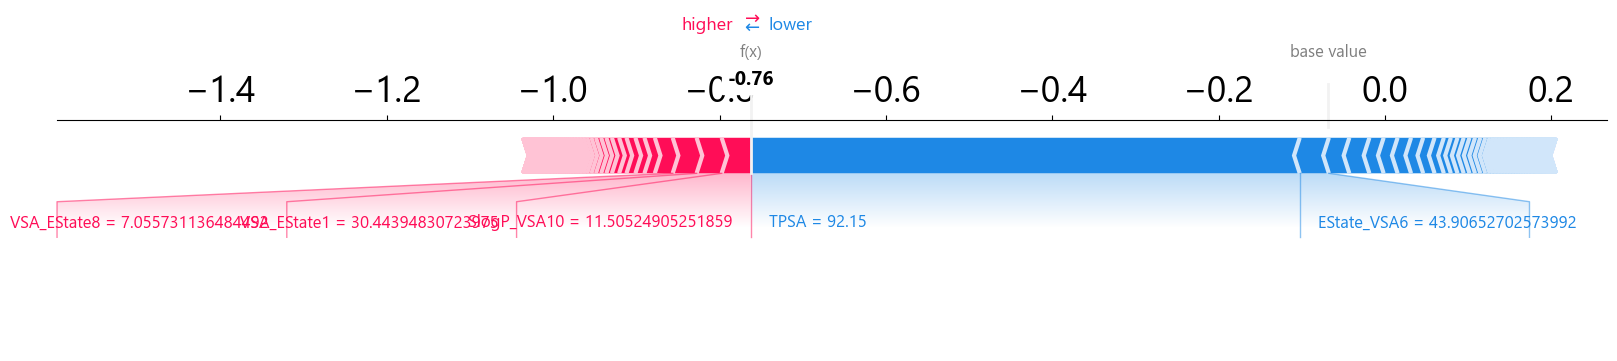

SHAP values for CC1=NC=CC=C1COC1=C(Cl)C=C(C2=CC(N3CCNCC3)=NC=C2)C=C1Cl:


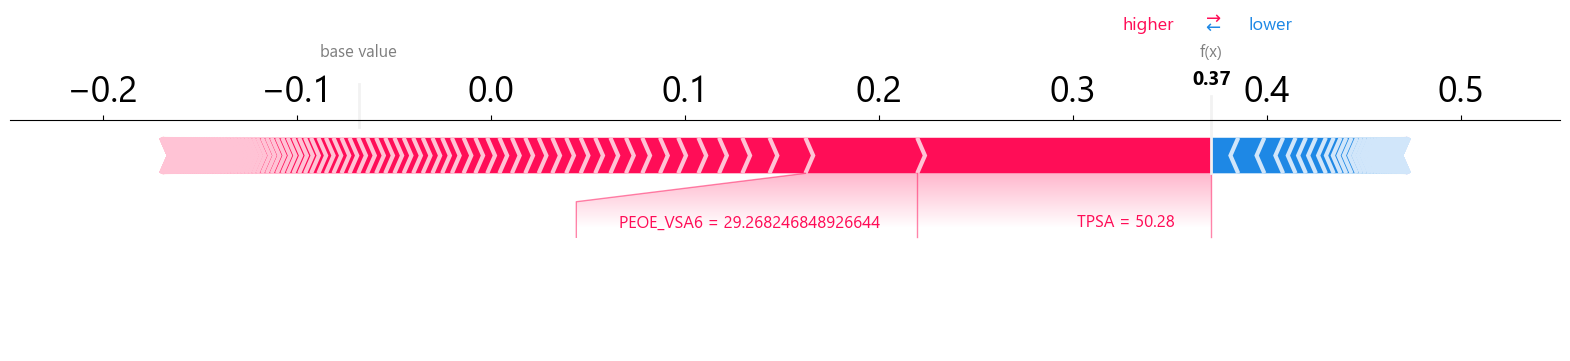

SHAP values for CC(C)CC1=NC=CC=C1COC1=C(Cl)C=C(C2=CC(N3CCNCC3)=NC=C2)C=C1Cl:


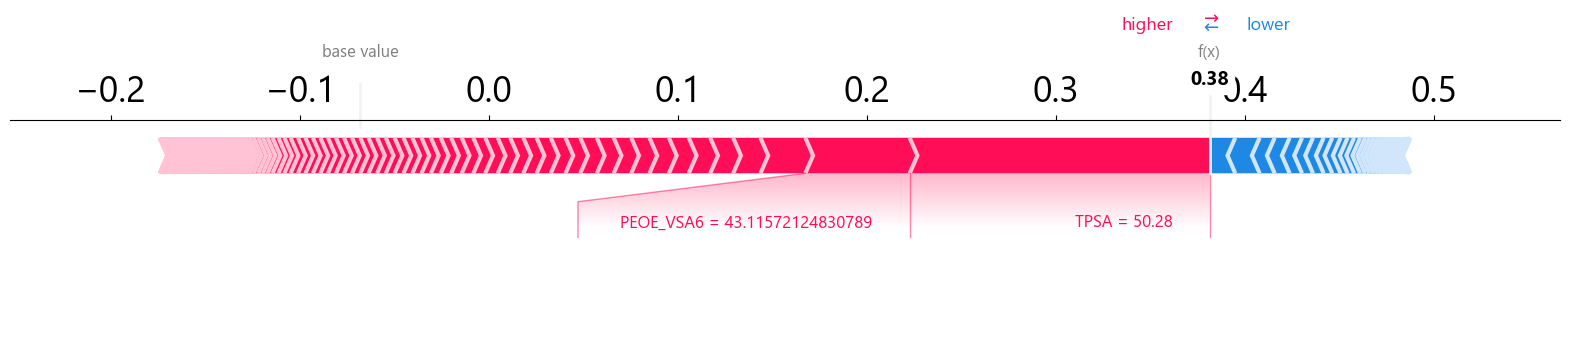

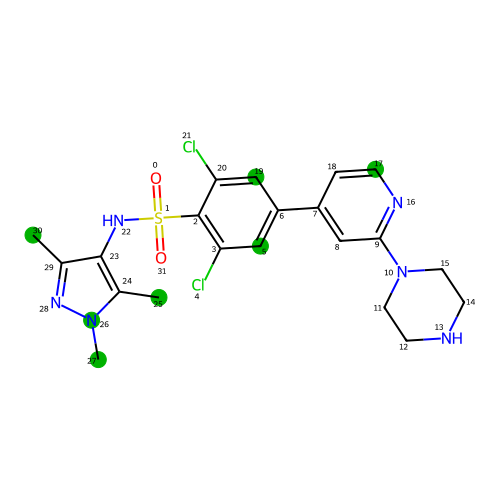

Saved SVG to manuscript/Figure_5/1_EState_VSA6.svg

### EState_VSA6 Contributions — Total: 43.9065
Bin range: 1.5400 to 1.8070
Idx Sym    Value     Contrib  % of total
--------------------------------------------
5   C      1.613       6.066        13.8%
17  C      1.731       6.197        14.1%
19  C      1.613       6.066        13.8%
25  C      1.781       6.924        15.8%
26  N      1.610       4.682        10.7%
27  C      1.748       7.048        16.1%
30  C      1.733       6.924        15.8%


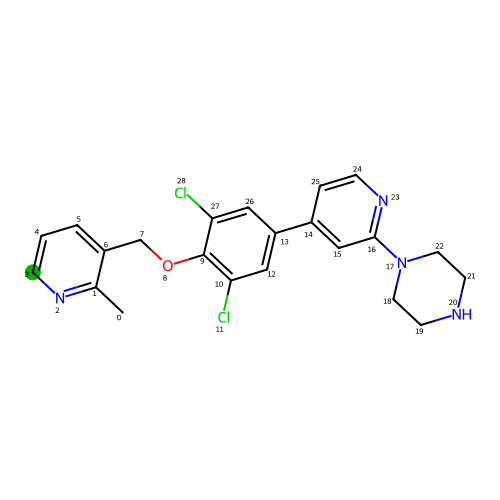

Saved SVG to manuscript/Figure_5/2_EState_VSA6.svg

### EState_VSA6 Contributions — Total: 6.1968
Bin range: 1.5400 to 1.8070
Idx Sym    Value     Contrib  % of total
--------------------------------------------
3   C      1.761       6.197       100.0%

No atoms contribute to EState_VSA6 (range 1.5400 to 1.8070).


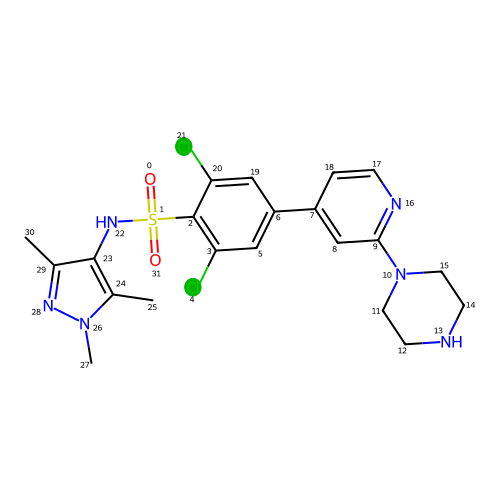

Saved SVG to manuscript/Figure_5/1_PEOE_VSA6.svg

### PEOE_VSA6 Contributions — Total: 23.2019
Bin range: -0.1000 to -0.0500
Idx Sym   Charge     Contrib  % of total
--------------------------------------------
4   Cl    -0.083      11.601        50.0%
21  Cl    -0.083      11.601        50.0%


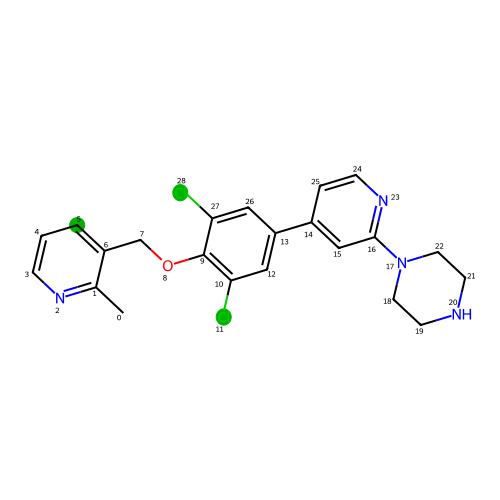

Saved SVG to manuscript/Figure_5/2_PEOE_VSA6.svg

### PEOE_VSA6 Contributions — Total: 29.2682
Bin range: -0.1000 to -0.0500
Idx Sym   Charge     Contrib  % of total
--------------------------------------------
5   C     -0.052       6.066        20.7%
11  Cl    -0.080      11.601        39.6%
28  Cl    -0.080      11.601        39.6%


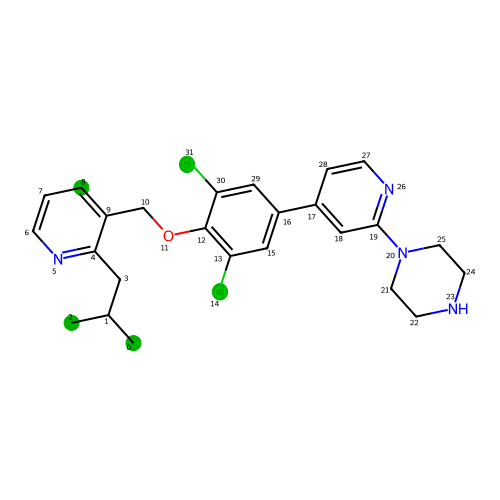

Saved SVG to manuscript/Figure_5/3_PEOE_VSA6.svg

### PEOE_VSA6 Contributions — Total: 43.1157
Bin range: -0.1000 to -0.0500
Idx Sym   Charge     Contrib  % of total
--------------------------------------------
0   C     -0.062       6.924        16.1%
2   C     -0.062       6.924        16.1%
8   C     -0.052       6.066        14.1%
14  Cl    -0.080      11.601        26.9%
31  Cl    -0.080      11.601        26.9%


In [20]:
# Figure 1
mol_1 = 'O=S(C1=C(Cl)C=C(C2=CC(N3CCNCC3)=NC=C2)C=C1Cl)(NC4=C(C)N(C)N=C4C)=O'
mol_2 = 'CC1=NC=CC=C1COC1=C(Cl)C=C(C2=CC(N3CCNCC3)=NC=C2)C=C1Cl'
mol_3 = 'CC(C)CC1=NC=CC=C1COC1=C(Cl)C=C(C2=CC(N3CCNCC3)=NC=C2)C=C1Cl'
fig_1 = [ mol_1, mol_2, mol_3]
for i, smi in enumerate(fig_1):
    desc = compute_descriptors(Chem.MolFromSmiles(smi), X.columns)
    desc_df = pd.DataFrame([desc], columns=X.columns)
    pred = rf.predict(desc_df.values.reshape(1, -1))
    print(f"Predicted logBB for molecule {i+32}: {pred[0]:.2f}")

X_new = pd.DataFrame([compute_descriptors(Chem.MolFromSmiles(smi), X.columns) for smi in fig_1], columns=X.columns)
X_new = X_new.replace([np.inf, -np.inf], np.nan).fillna(0)
shap_values_new = explainer(X_new)

# Force plot for a single molecule
for i in range(len(fig_1)):
    print(f"SHAP values for {fig_1[i]}:")
    shap.plots.force(
        explainer.expected_value,
        shap_values_new.values[i],
        X_new.iloc[i],
        matplotlib=True
    )
visualize_vsa_contributions(mol_1, ["EState_VSA6"], save_path= 'manuscript/Figure_5/1_EState_VSA6.svg')
visualize_vsa_contributions(mol_2, ["EState_VSA6"], save_path= 'manuscript/Figure_5/2_EState_VSA6.svg')
visualize_vsa_contributions(mol_3, ["EState_VSA6"],  save_path= 'manuscript/Figure_6/3_EState_VSA6.svg')

visualize_vsa_contributions(mol_1, ["PEOE_VSA6"], save_path= 'manuscript/Figure_5/1_PEOE_VSA6.svg')
visualize_vsa_contributions(mol_2, ["PEOE_VSA6"], save_path= 'manuscript/Figure_5/2_PEOE_VSA6.svg')
visualize_vsa_contributions(mol_3, ["PEOE_VSA6"],  save_path= 'manuscript/Figure_5/3_PEOE_VSA6.svg')

Predicted logBB for molecule 1: -0.79


c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted logBB for molecule 2: -0.36
SHAP values for OC1CCC(NC2=NC=CC(C3=C4C=CC=NN4N=C3)=N2)CC1:


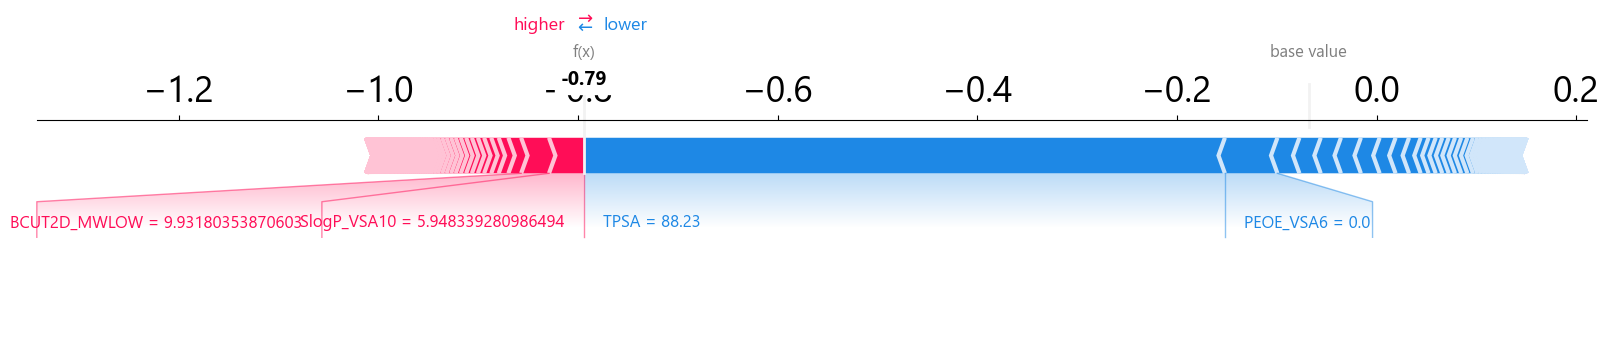

SHAP values for C1=CC2=C(C3=NC(NC4=CC=NC=C4)=NC=C3)C=NN2N=C1:


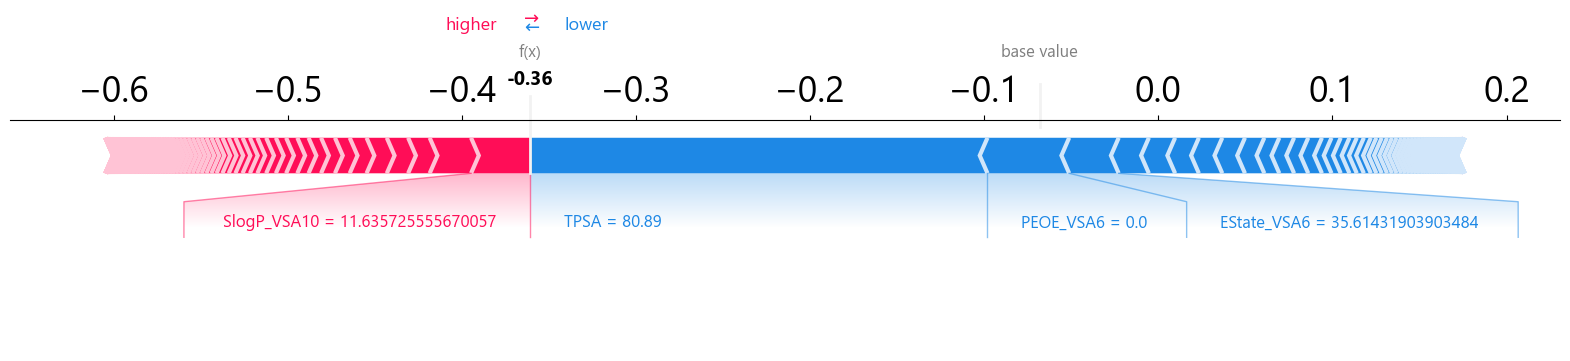


No atoms contribute to EState_VSA1 (range -inf to -0.3900).


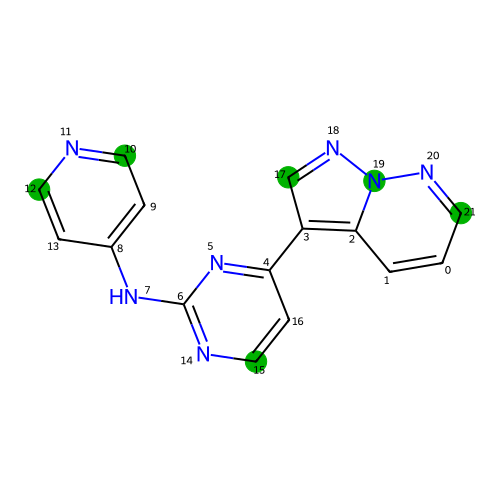

Saved SVG to manuscript/Figure_6/2_EState_VSA6.svg

### EState_VSA6 Contributions — Total: 35.6143
Bin range: 1.5400 to 1.8070
Idx Sym    Value     Contrib  % of total
--------------------------------------------
10  C      1.711       6.197        17.4%
12  C      1.711       6.197        17.4%
15  C      1.714       6.197        17.4%
17  C      1.751       6.197        17.4%
19  N      1.577       4.630        13.0%
21  C      1.695       6.197        17.4%


In [21]:
mol_1 = 'OC1CCC(NC2=NC=CC(C3=C4C=CC=NN4N=C3)=N2)CC1'
mol_2 = 'C1=CC2=C(C3=NC(NC4=CC=NC=C4)=NC=C3)C=NN2N=C1'
fig_7 = [ mol_1, mol_2 ]
for i, smi in enumerate(fig_7):
    desc = compute_descriptors(Chem.MolFromSmiles(smi), X.columns)
    desc_df = pd.DataFrame([desc], columns=X.columns)
    pred = rf.predict(desc_df.values.reshape(1, -1))
    print(f"Predicted logBB for molecule {i+1}: {pred[0]:.2f}")

X_new = pd.DataFrame([compute_descriptors(Chem.MolFromSmiles(smi), X.columns) for smi in fig_7], columns=X.columns)
X_new = X_new.replace([np.inf, -np.inf], np.nan).fillna(0)
shap_values_new = explainer(X_new)
# Force plot for a single molecule
for i in range(len(fig_7)):
    print(f"SHAP values for {fig_7[i]}:")
    shap.plots.force(
        explainer.expected_value,
        shap_values_new.values[i],
        X_new.iloc[i],
        matplotlib=True
    )

visualize_vsa_contributions(mol_1, ["EState_VSA1"], save_path= 'manuscript/Figure_6/1_EState_VSA6.svg')
visualize_vsa_contributions(mol_2, ["EState_VSA6"],  save_path= 'manuscript/Figure_6/2_EState_VSA6.svg')

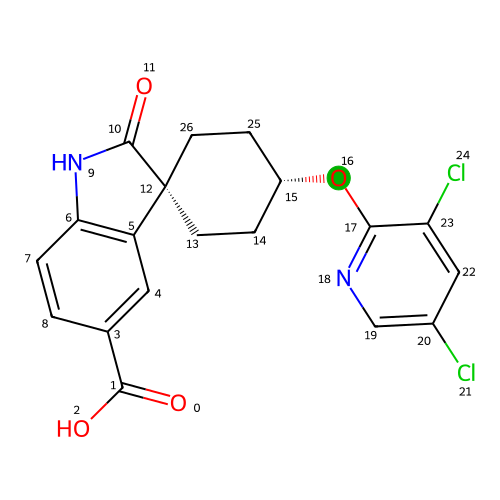


### VSA_EState1 Contributions — Total: 5.9015
Bin range: -inf to 4.7800
Idx Sym    Value     Contrib  % of total
--------------------------------------------
16  O      4.737       5.901       100.0%


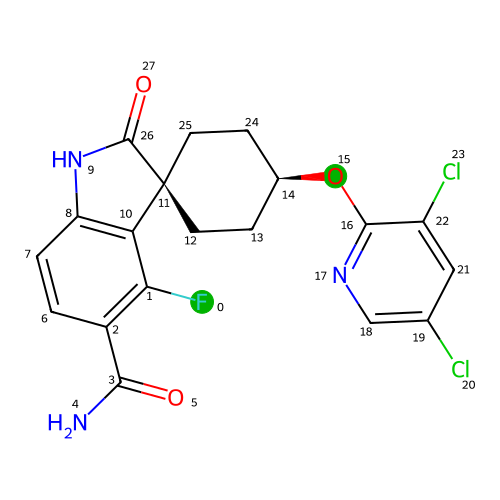


### VSA_EState1 Contributions — Total: 20.8557
Bin range: -inf to 4.7800
Idx Sym    Value     Contrib  % of total
--------------------------------------------
0   F      4.390      14.998        71.9%
15  O      4.737       5.858        28.1%


In [22]:
mol_1 = 'O=C(O)C1=CC2=C(C=C1)NC(=O)[C@]21CC[C@@H](OC2=NC=C(Cl)C=C2Cl)CC1'
mol_2 = 'FC1=C(C(N)=O)C=CC(N2)=C1[C@]3(CC[C@H](OC4=NC=C(Cl)C=C4Cl)CC3)C2=O'

#vizualize mol 1 and 2
visualize_vsa_contributions(mol_1, ["VSA_EState1"])
visualize_vsa_contributions(mol_2, ["VSA_EState1"])

Predicted logBB for molecule 1: -0.69


c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted logBB for molecule 2: -0.64
SHAP values for O=C(O)C1=CC2=C(C=C1)NC(=O)[C@]21CC[C@@H](OC2=NC=C(Cl)C=C2Cl)CC1:


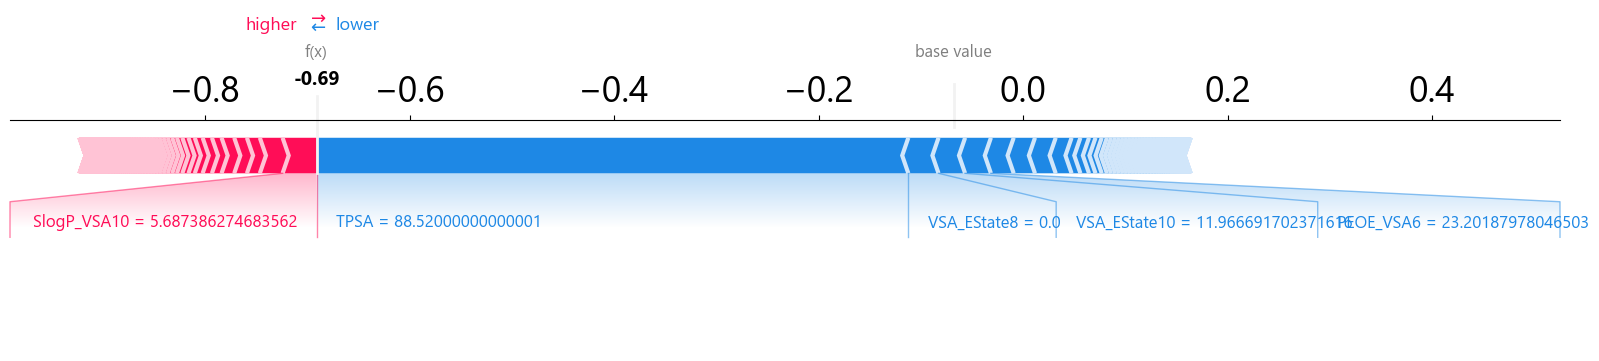

SHAP values for FC1=C(C(N)=O)C=CC(N2)=C1[C@]3(CC[C@H](OC4=NC=C(Cl)C=C4Cl)CC3)C2=O:


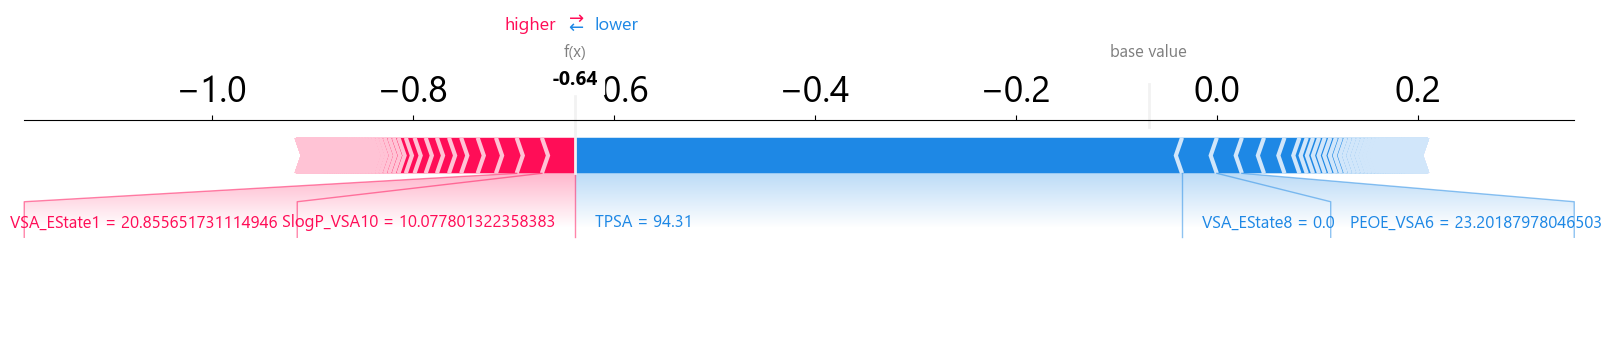

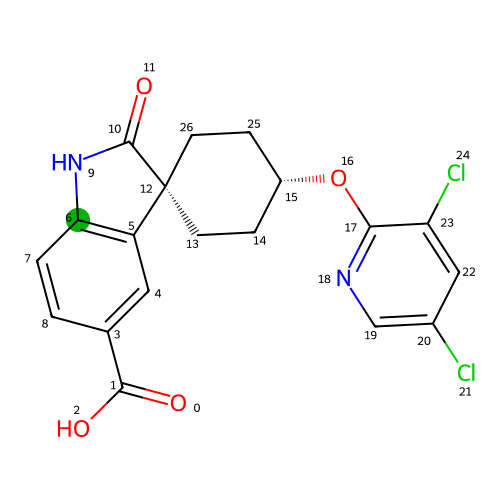

Saved SVG to manuscript/Figure_7/1_SlogP_VSA10.svg

### SlogP_VSA10 Contributions — Total: 5.6874
Bin range: 0.4000 to 0.5000
Idx Sym    Value     Contrib  % of total
--------------------------------------------
6   C      0.462       5.687       100.0%


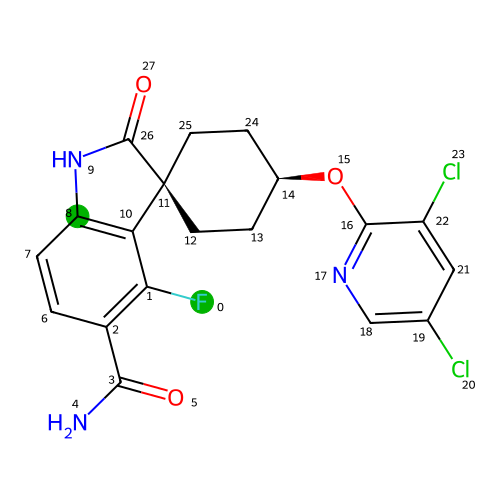

Saved SVG to manuscript/Figure_7/2_SlogP_VSA10.svg

### SlogP_VSA10 Contributions — Total: 10.0778
Bin range: 0.4000 to 0.5000
Idx Sym    Value     Contrib  % of total
--------------------------------------------
0   F      0.420       4.390        43.6%
8   C      0.462       5.687        56.4%


In [23]:
mol_1 = 'O=C(O)C1=CC2=C(C=C1)NC(=O)[C@]21CC[C@@H](OC2=NC=C(Cl)C=C2Cl)CC1'
mol_2 = 'FC1=C(C(N)=O)C=CC(N2)=C1[C@]3(CC[C@H](OC4=NC=C(Cl)C=C4Cl)CC3)C2=O'
fig_7 = [ mol_1, mol_2 ]
for i, smi in enumerate(fig_7):
    desc = compute_descriptors(Chem.MolFromSmiles(smi), X.columns)
    desc_df = pd.DataFrame([desc], columns=X.columns)
    pred = rf.predict(desc_df.values.reshape(1, -1))
    print(f"Predicted logBB for molecule {i+1}: {pred[0]:.2f}")

X_new = pd.DataFrame([compute_descriptors(Chem.MolFromSmiles(smi), X.columns) for smi in fig_7], columns=X.columns)
X_new = X_new.replace([np.inf, -np.inf], np.nan).fillna(0)
shap_values_new = explainer(X_new)
# Force plot for a single molecule
for i in range(len(fig_7)):
    print(f"SHAP values for {fig_7[i]}:")
    shap.plots.force(
        explainer.expected_value,
        shap_values_new.values[i],
        X_new.iloc[i],
        matplotlib=True
    )

visualize_vsa_contributions(mol_1, ["SlogP_VSA10"], save_path= 'manuscript/Figure_7/1_SlogP_VSA10.svg')
visualize_vsa_contributions(mol_2, ["SlogP_VSA10"],  save_path= 'manuscript/Figure_7/2_SlogP_VSA10.svg')

Unknown descriptor: MaxAbsEStateIndex
Unknown descriptor: MaxEStateIndex
Unknown descriptor: MinAbsEStateIndex
Unknown descriptor: MinEStateIndex
Unknown descriptor: qed
Unknown descriptor: SPS
Unknown descriptor: MolWt
Unknown descriptor: HeavyAtomMolWt
Unknown descriptor: ExactMolWt
Unknown descriptor: NumValenceElectrons
Unknown descriptor: NumRadicalElectrons
Unknown descriptor: MaxPartialCharge
Unknown descriptor: MinPartialCharge
Unknown descriptor: MaxAbsPartialCharge
Unknown descriptor: MinAbsPartialCharge
Unknown descriptor: FpDensityMorgan1
Unknown descriptor: FpDensityMorgan2
Unknown descriptor: FpDensityMorgan3
Unknown descriptor: BCUT2D_MWHI
Unknown descriptor: BCUT2D_MWLOW
Unknown descriptor: BCUT2D_CHGHI
Unknown descriptor: BCUT2D_CHGLO
Unknown descriptor: BCUT2D_LOGPHI
Unknown descriptor: BCUT2D_LOGPLOW
Unknown descriptor: BCUT2D_MRHI
Unknown descriptor: BCUT2D_MRLOW
Unknown descriptor: AvgIpc
Unknown descriptor: BalabanJ
Unknown descriptor: BertzCT
Unknown descriptor: 

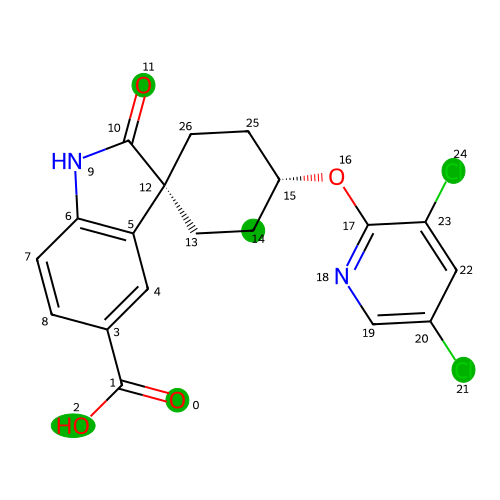

Unknown descriptor: MaxAbsEStateIndex
Unknown descriptor: MaxEStateIndex
Unknown descriptor: MinAbsEStateIndex
Unknown descriptor: MinEStateIndex
Unknown descriptor: qed
Unknown descriptor: SPS
Unknown descriptor: MolWt
Unknown descriptor: HeavyAtomMolWt
Unknown descriptor: ExactMolWt
Unknown descriptor: NumValenceElectrons
Unknown descriptor: NumRadicalElectrons
Unknown descriptor: MaxPartialCharge
Unknown descriptor: MinPartialCharge
Unknown descriptor: MaxAbsPartialCharge
Unknown descriptor: MinAbsPartialCharge
Unknown descriptor: FpDensityMorgan1
Unknown descriptor: FpDensityMorgan2
Unknown descriptor: FpDensityMorgan3
Unknown descriptor: BCUT2D_MWHI
Unknown descriptor: BCUT2D_MWLOW
Unknown descriptor: BCUT2D_CHGHI
Unknown descriptor: BCUT2D_CHGLO
Unknown descriptor: BCUT2D_LOGPHI
Unknown descriptor: BCUT2D_LOGPLOW
Unknown descriptor: BCUT2D_MRHI
Unknown descriptor: BCUT2D_MRLOW
Unknown descriptor: AvgIpc
Unknown descriptor: BalabanJ
Unknown descriptor: BertzCT
Unknown descriptor: 

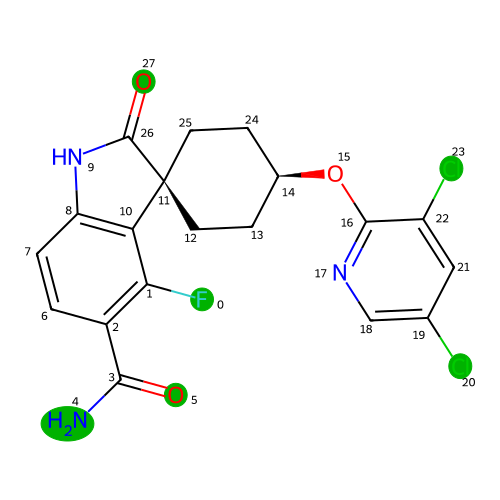

In [24]:
from vsa_explainer import highlight_top_contributing_atoms
highlight_top_contributing_atoms(smiles= mol_1, descriptors= X.columns, number_atoms=6, mode="percentage")
highlight_top_contributing_atoms(smiles= mol_2, descriptors= X.columns, number_atoms=6, mode="percentage")